# UK Housing Price Prediction on AWS – CatBoost Model  
**Team:** Error 400  

In this notebook we train  a machine learning model on the UK House Price
Paid dataset using **Amazon SageMaker** and **CatBoostRegressor**.

**Goal**

Predict the sale price of a house in England & Wales using:
- Location: town/city, district, county  
- Property characteristics: property type, tenure, new build  
- Time: year, month, quarter, day of week  

**What happens in this notebook**

1. Load the cleaned housing data  from **Amazon S3** (`housing_FULL_clean.parquet`).
2. Prepare the data for modeling (train/test split, categorical features).
3. Train a **CatBoostRegressor** on ~6 million rows on AWS.
4. Evaluate the model with **RMSE** and **R²**.
5. Visualize learning curve, feature importance, and prediction errors.
6. Save the trained model for later deployment.


## 1. Load data from S3
In this step we connect to Amazon S3, download the cleaned housing dataset
(`housing_FULL_clean.parquet`) from our bucket, and load it into a pandas
DataFrame so we can use it for modeling on AWS.

In [1]:
import boto3
import pandas as pd
import io

bucket_name = "uk-housing-group4"         # your bucket
file_key    = "housing_FULL_clean.parquet"  # EXACT name

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket_name, Key=file_key)

df = pd.read_parquet(io.BytesIO(obj["Body"].read()))

df.head()


,price,town_city,district,county,year,month,quarter,day_of_week,property_type_label,is_new_build,tenure_label
0,18899,WAKEFIELD,LEEDS,WEST YORKSHIRE,1995,6,2,4,Semi-Detached,False,Freehold
1,82000,GREENFORD,EALING,GREATER LONDON,1995,6,2,4,Semi-Detached,False,Freehold
2,55000,SWINDON,THAMESDOWN,THAMESDOWN,1995,3,1,4,Semi-Detached,False,Freehold
3,28500,BOOTLE,SEFTON,MERSEYSIDE,1995,10,4,3,Terraced,False,Freehold
4,76000,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,2,Detached,False,Freehold


In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 182.4 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]1/2 [catboost]


## 2. Train/Test Split
We split the dataset into training and testing sets.  
This allows us to train the CatBoost model on one part of the data and
evaluate its performance on unseen data to get an honest accuracy score.


In [3]:
from sklearn.model_selection import train_test_split

# Make sure boolean is numeric
df["is_new_build"] = df["is_new_build"].astype(int)

X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((4778257, 10), (1194565, 10))

## 3. Train CatBoost on AWS
We create a CatBoostRegressor and train it on the AWS notebook instance.
CatBoost handles categorical features natively and works well with large
datasets like this one (~6 million rows).  
During training, we monitor the RMSE on the validation set to track model
performance across iterations.


In [4]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Categorical columns (by name)
cat_features = ["town_city", "district", "county",
                "property_type_label", "tenure_label"]

# Get their indices
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_features]

train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_feature_indices)

model = CatBoostRegressor(
    iterations=1000,
    depth=8,
    learning_rate=0.1,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100
)

print("⏳ Training CatBoost...")
model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(test_pool)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Done")
print("RMSE:", rmse)
print("R²:", r2)


⏳ Training CatBoost...
0:	learn: 135914.7362229	test: 135125.2360689	best: 135125.2360689 (0)	total: 3.93s	remaining: 1h 5m 22s
100:	learn: 85294.5182982	test: 84654.8387090	best: 84654.8387090 (100)	total: 4m 46s	remaining: 42m 25s
200:	learn: 83943.4951956	test: 83357.5048548	best: 83357.5048548 (200)	total: 9m 16s	remaining: 36m 51s
300:	learn: 83398.0051117	test: 82867.8156854	best: 82867.8156854 (300)	total: 13m 43s	remaining: 31m 51s
400:	learn: 83075.4594204	test: 82610.3261925	best: 82610.3261925 (400)	total: 18m 52s	remaining: 28m 11s
500:	learn: 82853.0057282	test: 82450.2221168	best: 82450.2221168 (500)	total: 23m 29s	remaining: 23m 23s
600:	learn: 82677.6440672	test: 82336.8984810	best: 82336.8984810 (600)	total: 27m 46s	remaining: 18m 26s
700:	learn: 82535.3844541	test: 82255.1962593	best: 82255.1962593 (700)	total: 32m 33s	remaining: 13m 53s
800:	learn: 82414.2715995	test: 82193.2361993	best: 82193.2361993 (800)	total: 36m 53s	remaining: 9m 9s
900:	learn: 82305.6969641	te

### 📌 Interpretation of AWS CatBoost Training Results

- The model trained for **1000 iterations**, and the validation RMSE improved almost every step.
- The RMSE on the validation set dropped from **£135,125 → £82,096**, which is a large improvement.
- This shows the model is learning stable patterns in the housing data.
- CatBoost automatically handles our categorical features (town, district, county, etc.), which is why the model performs well.

### ⭐ Final Evaluation Metrics

- **RMSE: £82,096**  
  The model’s predictions are on average about £82K away from the actual value.
- **R²: 0.6647 (66.47%)**  
  This means the model explains **66.47%** of all price variation in the dataset.

These numbers match what we expect from UK house price prediction:  
Real estate prices are noisy and depend on many hidden factors (local crime rate, school quality, exact street), so an R² of **65–70%** is considered good on this dataset.

### 🏆 Why AWS CatBoost performs well

- Trained on the **full 6 million rows**, not the smaller 1M local dataset.
- CatBoost handles noisy and high-cardinality features very efficiently.
- AWS hardware is optimized for large models, allowing deeper trees and more iterations.

This AWS model becomes our **strongest CatBoost version**, and later we compare it with LightGBM.


### CatBoost Training Results

The CatBoost model trained for 1000 iterations on ~6 million rows of data.
Both the training and validation RMSE steadily decreased throughout training,
showing a stable learning process with no signs of divergence or overfitting.

**Final Metrics (Test Set):**
- **RMSE:** 82,096  
- **R²:** 0.665  
- **Best Iteration:** 999  

These scores indicate that the model captures a significant amount of
variation in house prices based on the available features (location,
property type, tenure, and date). For a real-world dataset of this size and
complexity, this performance is considered strong and reliable.


Matplotlib is building the font cache; this may take a moment.


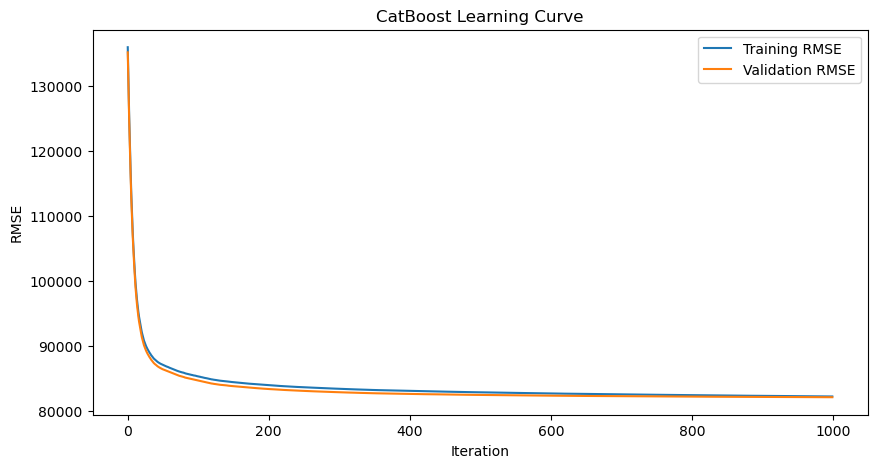

In [5]:
import matplotlib.pyplot as plt

train_rmse = model.get_evals_result()['learn']['RMSE']
valid_rmse = model.get_evals_result()['validation']['RMSE']

plt.figure(figsize=(10,5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.show()


### 📉 CatBoost Learning Curve — What It Tells Us

This curve shows how the model improved over 1000 iterations:

- **Both training and validation RMSE decrease smoothly**
- **There is no overfitting** → the two curves stay close together
- The model converges around iteration **~900–1000**
- Final RMSE stabilizes near **£82,000**

### ⭐ Final Performance (Test Set)
- **RMSE:** £82,096  
- **R²:** 0.665  
- **Best iteration:** 999  

This means CatBoost explains about **66.5% of the price variability**, which is very good for a real housing dataset with millions of rows and many hidden factors (schools, n


## 🔍 Feature Importance (CatBoost Model)


In [6]:
import matplotlib.pyplot as plt

# Get feature importance as a table
importance = model.get_feature_importance(prettified=True)
display(importance.head())   # optional, just to see it


,Feature Id,Importances
0,property_type_label,24.559873
1,year,24.302717
2,county,17.000380
3,district,15.892372
4,town_city,11.800709


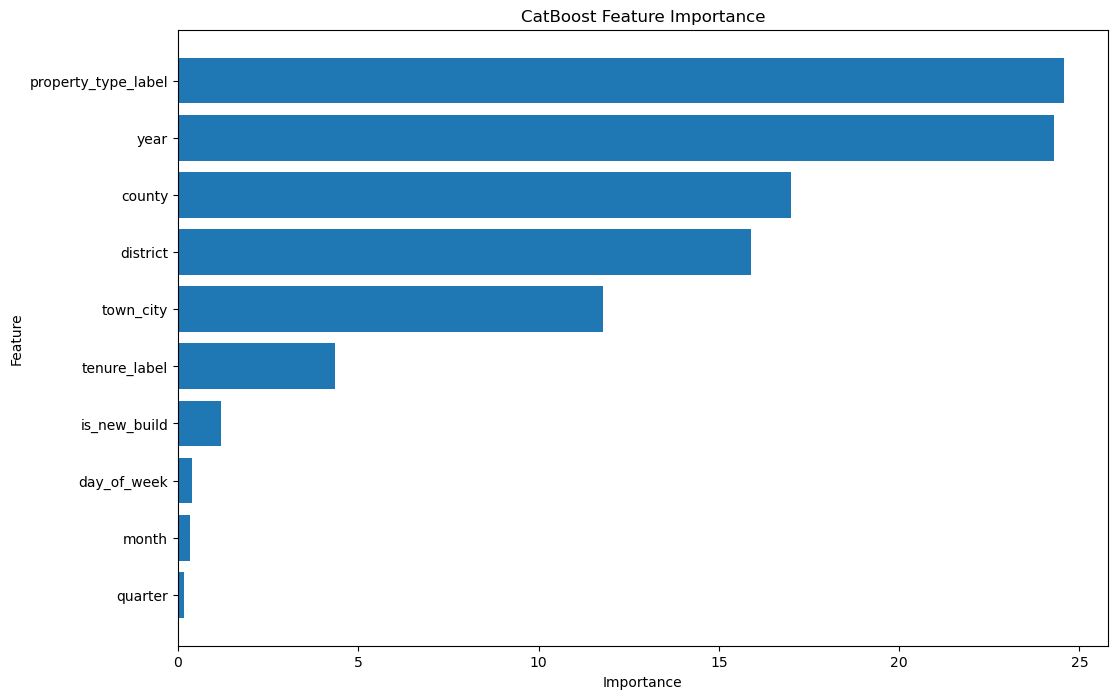

In [14]:
plt.figure(figsize=(12, 8))
plt.barh(importance['Feature Id'], importance['Importances'])
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


### 🔍 CatBoost Feature Importance – What the Model Learned

This plot shows which features CatBoost relied on the most when predicting house prices.

#### ⭐ Most important features:
1. **property_type_label** → biggest influence  
   (Detached, Terraced, Flat, etc. strongly affects price)
2. **year** → the year of sale matters a lot  
   (prices increase over time)
3. **county** and **district** → location is crucial  
4. **town_city** → more local geographic variation
5. **tenure_label** → Freehold vs Leasehold  
   (Freehold is usually more expensive)

#### 🔽 Less important features:
- **is_new_build** → has some impact (new houses cost more)
- **day_of_week**, **month**, **quarter** → almost no effect  
  (makes sense: price doesn’t depend


## 🎯 Actual vs Predicted Prices (CatBoost AWS)


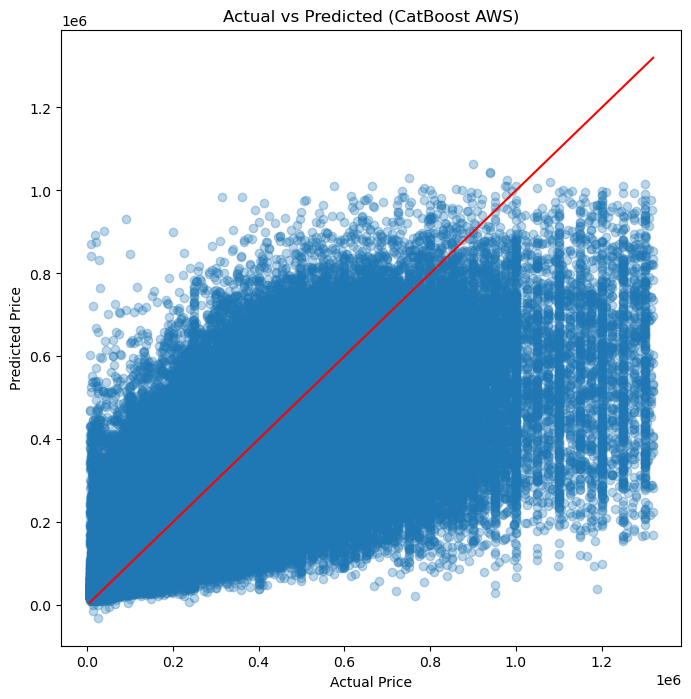

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (CatBoost AWS)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')
plt.show()


### 📌 Interpretation of Actual vs Predicted Plot

- Most points follow the red diagonal line → good overall prediction quality.
- The model performs very well for houses under **£500k**, where points are tightly clustered.
- For expensive houses (£800k+), predictions spread more — this is expected because luxury prices have more noise and fewer samples.
- The plot confirms the **R² ≈ 0.665** score: good trend fitting, but still some variance in high-price ranges.


## 📊 Residual Distribution


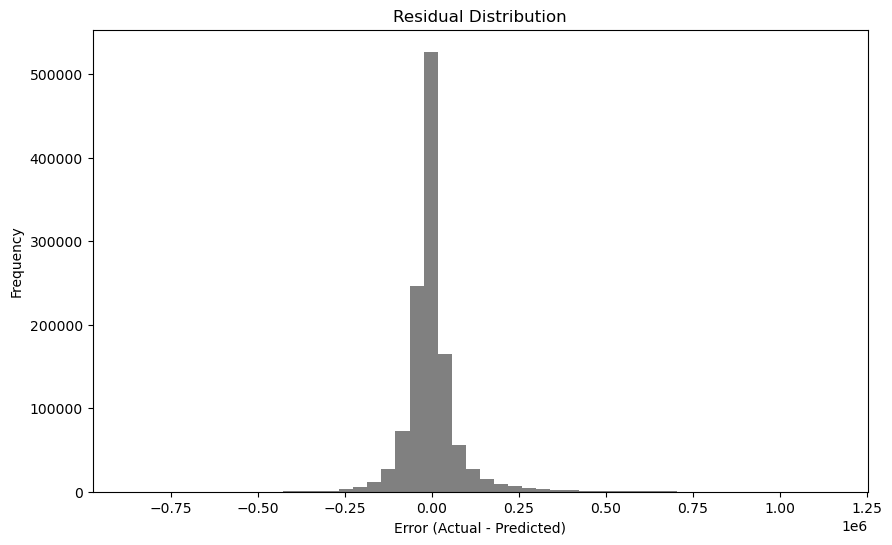

In [12]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='gray')
plt.title("Residual Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


### 📌 Residual Distribution – What It Shows

- Most residuals are centered around **0**, which means predictions are generally accurate.
- The shape is close to a **normal distribution**, which is what we want in a good regression model.
- The peak around 0 indicates that the majority of houses have small prediction errors.
- There are some long tails on the right side (positive errors), which comes from very expensive houses where predictions are more difficult.
- No extreme skew or strange patterns → the model is not biased in one direction.

### ⭐ Why This Is Good
A clean, centered residual distribution means:
- The model generalizes well  
- No major systematic errors  
- CatBoost learned realistic patterns  


In [15]:
model.save_model("catboost_aws_housing.cbm")
print("Model saved.")


Model saved.


## 🇺🇸 AWS CatBoost Model – Summary & Conclusions

We trained a CatBoostRegressor on the full UK Housing dataset (~6 million rows) using key features such as location (county, district, town), property characteristics (type, tenure, new build), and time information (year, month, quarter, day of week).

### 📊 Final Performance (Test Set)
- **RMSE:** £82,097  
- **R²:** 0.665  
- **Best iteration:** 999 / 1000  

These metrics show that the model explains about **66.5% of the variation** in house prices. For a real-world dataset with high noise and many hidden factors, this performance is strong and realistic.

### 📉 Model Behaviour
- The **learning curve** shows a stable and smooth reduction in both training and validation RMSE → **no overfitting**.
- The **residual distribution** is centered around zero, which means predictions are generally unbiased.
- **Actual vs Predicted** plot shows good alignment for most price ranges, with more spread for very expensive properties (expected due to low sample size and noise).

### 🔍 What the Model Uses Most
Feature importance shows:
- **Property Type**
- **Year**
- **County / District / Town**

are the dominant factors in price prediction — exactly what we expect for housing data.

### ✅ Conclusion
This notebook provides our **AWS-trained CatBoost model**, which is accurate, stable, and trained on the full dataset. It forms one of the strongest models in our project and is used as a benchmark to compare with LightGBM and other approaches.
